# PREDICCIÓN DEL PRECIOS DE ACTIVOS FINANCIEROS EMPLEANDO APRENDIZAJE AUTOMÁTICO (PRE-COVID)
#### Autor: Samuel Valer Nasta

# Librerías empleadas

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns   
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasRegressor

# Preparación de los datos

Definimos las fechas de inicio y fin de train y test

In [2]:
fecha_inicio_train = '2010-01-01'
fecha_fin_train = '2023-01-01'
fecha_inicio_test = '2023-01-02'
fecha_fin_test = '2023-06-01'

Obtenemos los datos de train

In [3]:
datos_tesla = yf.download('TSLA', start=fecha_inicio_train, end=fecha_fin_train)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio_train, end=fecha_fin_train)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio_train, end=fecha_fin_train)
datos_petroleo = yf.download('CL=F', start=fecha_inicio_train, end=fecha_fin_train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Creamos un dataframe nuevo con solo el precio de cierre.

In [4]:
datos_tesla = datos_tesla.loc[:,'Adj Close'].copy() 
datos_sp500 = datos_sp500.loc[:,'Adj Close'].copy()
datos_bitcoin = datos_bitcoin.loc[:,'Adj Close'].copy()
datos_petroleo = datos_petroleo.loc[:,'Adj Close'].copy()

Normalizamos / escalamos las variables para que tomen valor entre 0 y 1

In [5]:
scaler_tesla =  MinMaxScaler(feature_range=(0,1))
scaler_sp500 =  MinMaxScaler(feature_range=(0,1))
scaler_bitcoin =  MinMaxScaler(feature_range=(0,1))
scaler_petroleo =  MinMaxScaler(feature_range=(0,1))

datos_tesla = scaler_tesla.fit_transform(np.array(datos_tesla).reshape(-1,1))
datos_sp500 = scaler_sp500.fit_transform(np.array(datos_sp500).reshape(-1,1))
datos_bitcoin = scaler_bitcoin.fit_transform(np.array(datos_bitcoin).reshape(-1,1))
datos_petroleo = scaler_petroleo.fit_transform(np.array(datos_petroleo).reshape(-1,1))

print(datos_tesla.shape,
      datos_sp500.shape,
      datos_bitcoin.shape,
      datos_petroleo.shape)

(3150, 1) (3272, 1) (3028, 1) (3272, 1)


Definimos una función para crear datos de train y test

In [6]:
def create_time_series_dataset(data, time_steps):
    """
    Crea un conjunto de datos de series temporales para el entrenamiento de modelos de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene dos arreglos numpy. El primer arreglo contiene las etiquetas de salida (y) y el segundo arreglo contiene las ventanas de tiempo de entrada (X).
    """

    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])    # Se crea una ventana de tiempo de longitud time_steps en la serie temporal de entrada
        y.append(data[i+time_steps])      # Se obtiene la etiqueta de salida correspondiente a la ventana de tiempo
    return np.array(y), np.array(X)      # Se devuelven las etiquetas de salida y las ventanas de tiempo de entrada como arreglos numpy en una tupla



Creamos los dataset, los dividimos en train y test luego los escalamos:

In [7]:
def preparar_datos_entrenamiento(datos, pasos):
    """
    Prepara los datos de entrenamiento para modelos de series temporales.

    Parámetros:
        - datos (array-like): Serie temporal de entrada.
        - pasos (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene cuatro arreglos numpy. Los primeros dos arreglos contienen las etiquetas de salida (y) y las ventanas de tiempo de entrada (X) respectivamente. Los otros dos arreglos contienen las ventanas de tiempo de entrada remodeladas (X_reg) para su uso en modelos que requieren datos en 2D.
    """

    y, X = create_time_series_dataset(datos, pasos)                    # Se crea el conjunto de datos de series temporales
    indices_barajados = np.random.permutation(len(y))                  # Se barajan los índices de las muestras
    X_train, y_train = X[indices_barajados], y[indices_barajados]      # Se obtienen las ventanas de tiempo y etiquetas de salida barajadas

    X_train_reg = X_train.reshape(X_train.shape[0], -1)                # Se remodelan las ventanas de tiempo para su uso en modelos que requieren datos en 2D

    return X_train, y_train, X_train_reg, y_train

Descagramos datos nuevos (test) para gráficar y hacer pruebas.

In [8]:
datos_tesla_test = yf.download('TSLA', start=fecha_inicio_test, end=fecha_fin_test)
datos_sp500_test = yf.download('^GSPC', start=fecha_inicio_test, end=fecha_fin_test)
datos_bitcoin_test = yf.download('BTC-USD', start=fecha_inicio_test, end=fecha_fin_test) 
datos_petroleo_test = yf.download('CL=F', start=fecha_inicio_test, end=fecha_fin_test)

datos_tesla_test = datos_tesla_test.loc[:,'Adj Close'].copy() # todo ajustado
datos_sp500_test = datos_sp500_test.loc[:,'Adj Close'].copy()
datos_bitcoin_test = datos_bitcoin_test.loc[:,'Adj Close'].copy()
datos_petroleo_test = datos_petroleo_test.loc[:,'Adj Close'].copy()

datos_tesla_test = scaler_tesla.transform(np.array(datos_tesla_test).reshape(-1,1))
datos_sp500_test = scaler_sp500.transform(np.array(datos_sp500_test).reshape(-1,1))
datos_bitcoin_test = scaler_bitcoin.transform(np.array(datos_bitcoin_test).reshape(-1,1))
datos_petroleo_test = scaler_petroleo.transform(np.array(datos_petroleo_test).reshape(-1,1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Modelos de aprendizaje automático

Usaremos las sigueintes métricas para evaluar los modelos:
   * RMSE (raíz del error cuadrático medio): esta métrica es útil para evaluar la precisión de la predicción del modelo en la misma escala que los valores de la variable objetivo.

   * MSE (error cuadrático medio): al igual que el RMSE, el MSE mide la precisión de la predicción del modelo. Sin embargo, como los errores están al cuadrado, el MSE puede dar más peso a los errores grandes.

   * MAE (error absoluto medio): esta métrica es una buena opción para evaluar la precisión de la predicción en una escala fácil de interpretar. El MAE es la media de las diferencias absolutas entre las predicciones y los valores reales.

   * R2 SCORE (coeficiente de determinación): esta métrica mide la proporción de la varianza en los valores de la variable objetivo que se explica por el modelo. Es una medida útil para evaluar el ajuste del modelo en general.


### Evaluación de los modelos

In [9]:
def evaluate_model(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name, color='blue')
    ax.set_title(name)

### Funciones para las predicciones continuas

In [10]:
def evaluate_model_seguidos(y_pred, y_test, name, ax, scaler):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales para predicciones continuas.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.
        - dias (int): Número de días a mostrar en la gráfica.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:11], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:10], label=name, color='blue')
    ax.set_title(name)

In [11]:
def predict_n_days(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando un modelo de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        aux = X.reshape(-1, 1).T           # Se ajusta la forma de las características de entrada según el modelo
        y_pred = model.predict(aux)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

In [12]:
def predict_n_days_red(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando redes neuronales.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        X = X.reshape(X.shape[1], X.shape[0] , 1)
        y_pred = model.predict(X, verbose=False)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        data = data.reshape(-1, 1)

        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

## Regresión Lineal

### Preparación de datos

In [13]:
pasos = 2 # Número de pasos de tiempo en cada ventana
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)

### Entrenamiento

In [14]:
model_lr_tesla = LinearRegression()
model_lr_tesla.fit(x_train_tesla_reg, y_train_tesla)

model_lr_sp500 = LinearRegression()
model_lr_sp500.fit(x_train_sp500_reg, y_train_sp500)

model_lr_bitcoin = LinearRegression()
model_lr_bitcoin.fit(x_train_bitcoin_reg, y_train_bitcoin)

model_lr_petroleo = LinearRegression()
model_lr_petroleo.fit(x_train_petroleo_reg, y_train_petroleo)


LinearRegression()

### Comparación entre el precio predicho y el precio de cierre ajustado real (día siguiente)

Tesla (TSLA)
RMSE:  6.4077877337001885
MSE:  41.059743640158594
MAE:  4.908831532503894
R²:  0.9330130113812308


SP500 (^GSPC)
RMSE:  38.75484513756994
MSE:  1501.938021637028
MAE:  31.03208536750399
R²:  0.8237831300528757


Bitcoin (BTC-USD)
RMSE:  635.6732432236262
MSE:  404080.4721504434
MAE:  448.2328991344785
R²:  0.9672971352455263


Petroleo (CL=F)
RMSE:  1.673349400566402
MSE:  2.800098216375937
MAE:  1.3261188934887798
R²:  0.8165967210408971




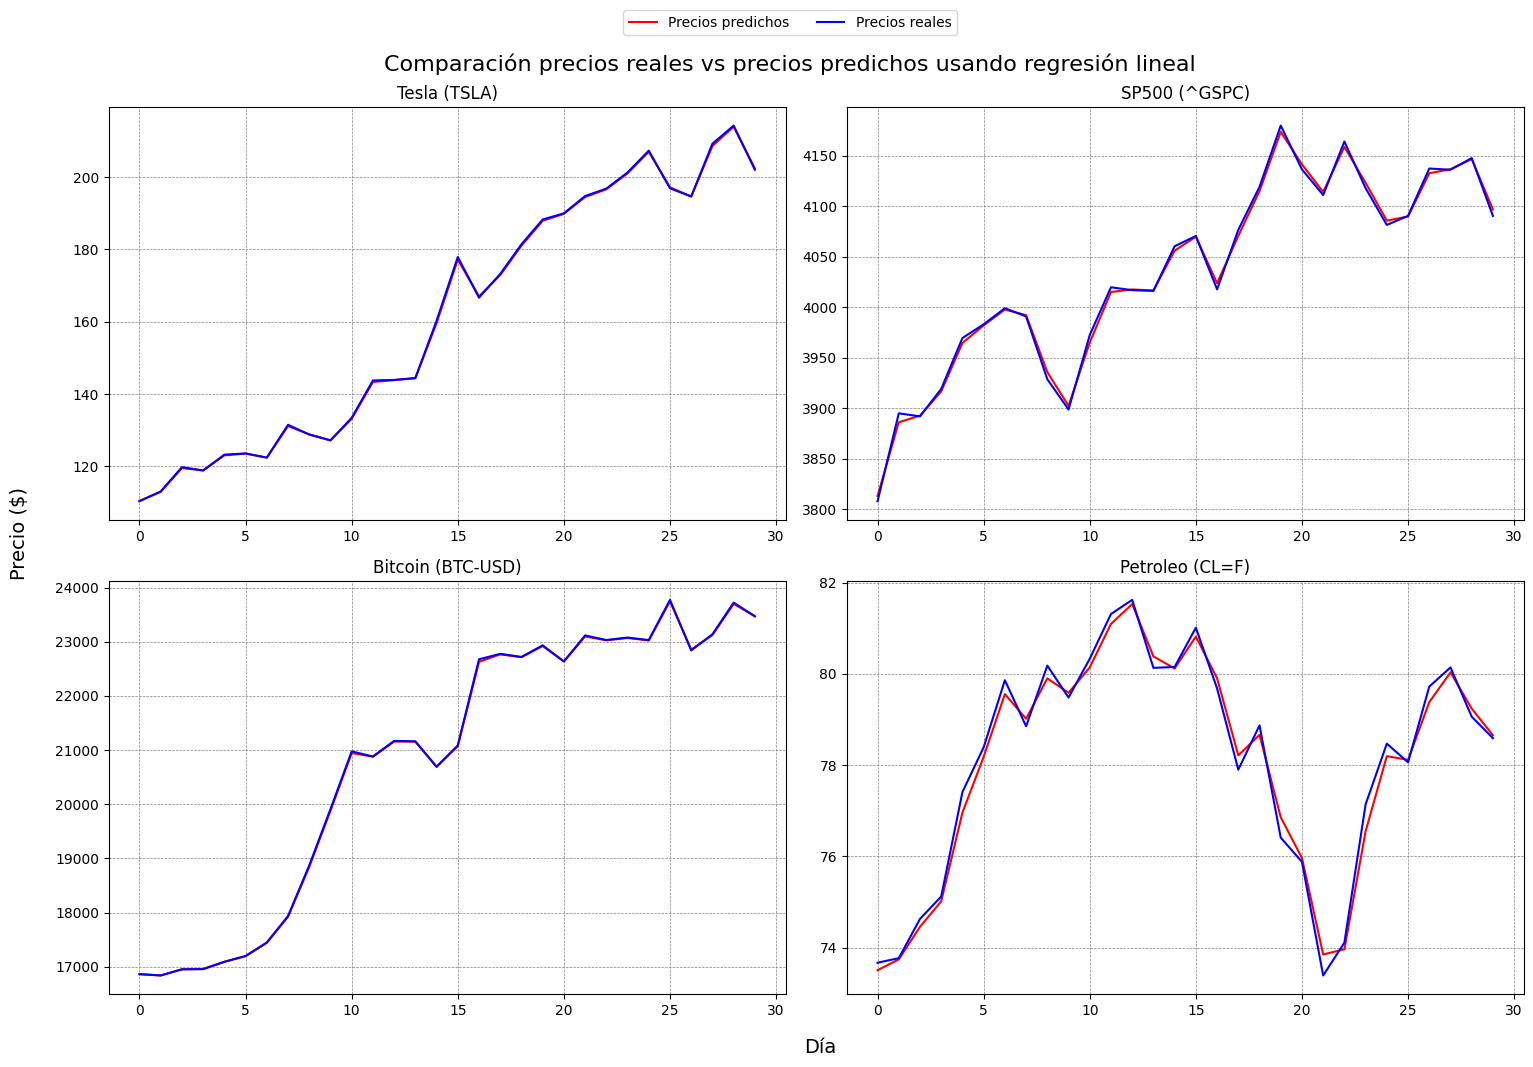

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_lr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = model_lr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = model_lr_bitcoin.predict(x_bitcoin_t_reg) 
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = model_lr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  20.95231795187854
MSE:  438.99962755661176
MAE:  16.759827473957934
R²:  -114263.43771444901


SP500 (^GSPC)
RMSE:  122.06912229766479
MSE:  14900.870618522244
MAE:  110.37153022040962
R²:  -5070.2408858203535


Bitcoin (BTC-USD)
RMSE:  2708.172490268745
MSE:  7334198.237048417
MAE:  2043.8746764357904
R²:  -1077375.0925680134


Petroleo (CL=F)
RMSE:  5.571382019110302
MSE:  31.040297602865582
MAE:  4.883127472865843
R²:  -13077.151854378586




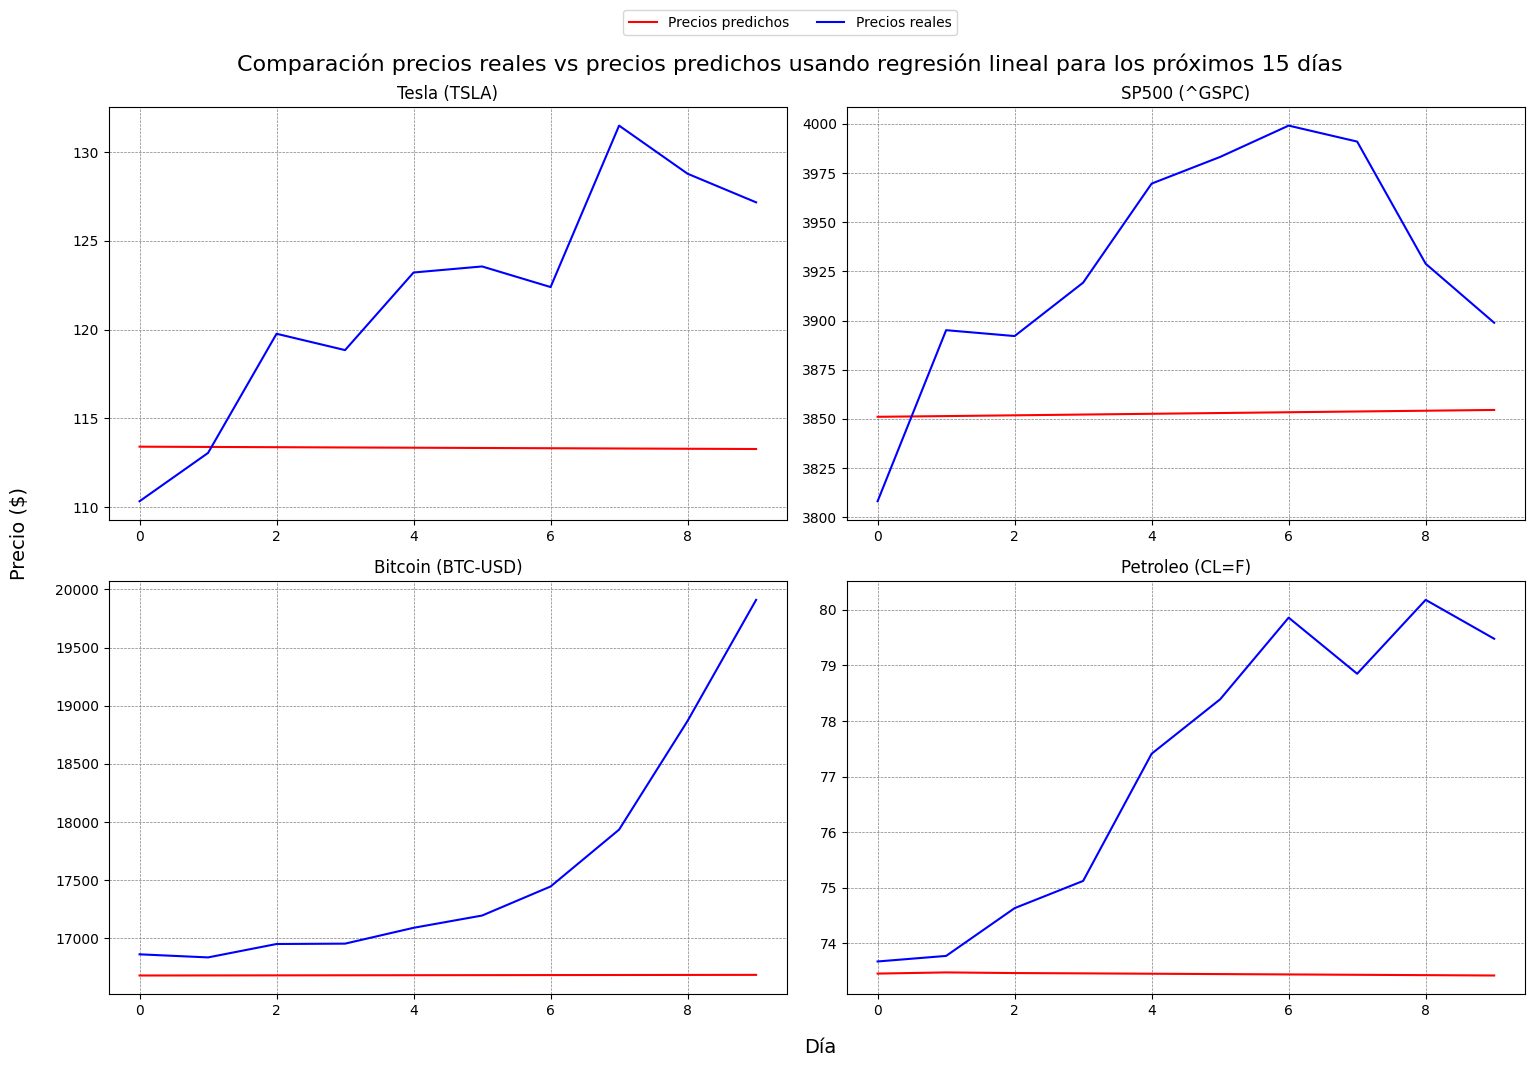

In [16]:
ventana = pasos
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:ventana], ventana, dias, model_lr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:ventana], ventana, dias, model_lr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:ventana], ventana, dias, model_lr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:ventana], ventana, dias, model_lr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

## SVR

Volvemos a preparar los datos ya que este modelo empelará una ventana diferente:

In [17]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 10
pasos_sp500 = 5
pasos_bitcoin = 10
pasos_petroleo = 10

y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)


In [18]:
param_grid = {'C': [1, 10, 100, 200, 300, 500, 600, 800, 1000, 1500, 2000, 3500, 4000, 4500, 10000, 20000, 30000, 40000, 50000, 60000, 61000], 
              'gamma': [1, 0.1, 0.2, 0.4, 0.8, 0.001,0.002,0.004,0.006, 0.0008, 0.000012, 0.000013, 0.000014, 0.000015, 0.000016, 0.000017, 0.000018, 0.000019], 
              'kernel': ['linear', 'rbf']}

model_svr_tesla = SVR()
grid_search = GridSearchCV(model_svr_tesla, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_tesla_reg, np.ravel(y_train_tesla))
model_svr_tesla = grid_search.best_estimator_
best_params_tesla_svr = grid_search.best_params_

print("Mejores parámetros para Tesla: ", grid_search.best_params_)
print("Mejor resultado para Tesla: ", grid_search.best_score_)


model_svr_sp500 = SVR()
grid_search = GridSearchCV(model_svr_sp500, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_sp500_reg, np.ravel(y_train_sp500))
model_svr_sp500 = grid_search.best_estimator_
best_params_sp500_svr = grid_search.best_params_

print("Mejores parámetros para SP500: ", grid_search.best_params_)
print("Mejor resultado para SP500: ", grid_search.best_score_)


model_svr_bitcoin = SVR()
grid_search = GridSearchCV(model_svr_bitcoin, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_bitcoin_reg, np.ravel(y_train_bitcoin))
model_svr_bitcoin = grid_search.best_estimator_
best_params_btc_svr = grid_search.best_params_

print("Mejores parámetros para Bitcoin: ", grid_search.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search.best_score_)


model_svr_petroleo = SVR()
grid_search = GridSearchCV(model_svr_petroleo, param_grid, cv=3, scoring='r2')
grid_search.fit(x_train_petroleo_reg, np.ravel(y_train_petroleo))
model_svr_petroleo = grid_search.best_estimator_
best_params_petroleo_svr = grid_search.best_params_

print("Mejores parámetros para Petróleo: ", grid_search.best_params_)
print("Mejor resultado para Petróleo: ", grid_search.best_score_)

Mejores parámetros para Tesla:  {'C': 100, 'gamma': 0.006, 'kernel': 'rbf'}
Mejor resultado para Tesla:  0.9786802270682667
Mejores parámetros para SP500:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Mejor resultado para SP500:  0.983395481899846
Mejores parámetros para Bitcoin:  {'C': 300, 'gamma': 0.004, 'kernel': 'rbf'}
Mejor resultado para Bitcoin:  0.9825539315333147
Mejores parámetros para Petróleo:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Mejor resultado para Petróleo:  0.9670660905061647


Tesla (TSLA)
RMSE:  9.650317145048941
MSE:  93.12862100002555
MAE:  7.778244580650745
R²:  0.7652139549596941


SP500 (^GSPC)
RMSE:  78.36055370542095
MSE:  6140.376377020161
MAE:  63.076098706002426
R²:  -0.36418520785590336


Bitcoin (BTC-USD)
RMSE:  1445.2804400847865
MSE:  2088835.5504916739
MAE:  1290.7247027294006
R²:  0.7384548739872251


Petroleo (CL=F)
RMSE:  3.732406352207154
MSE:  13.930857177996316
MAE:  2.948894318955662
R²:  -0.20504769880625617




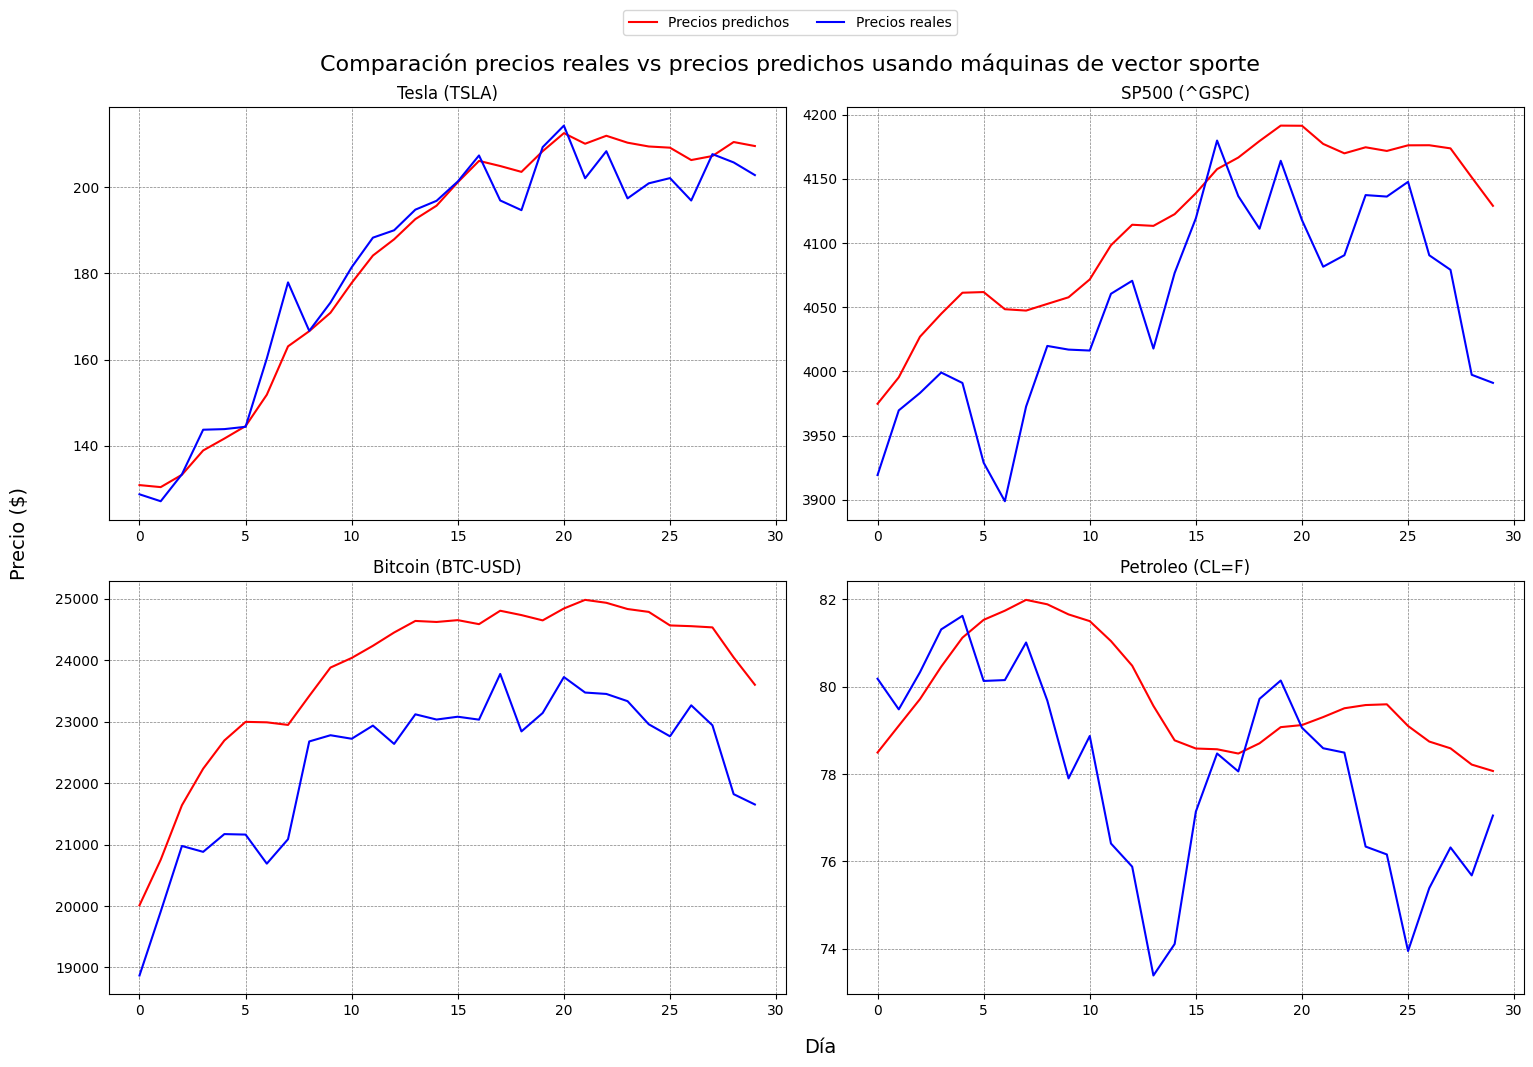

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_svr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = model_svr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = model_svr_bitcoin.predict(x_bitcoin_t_reg)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = model_svr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando máquinas de vector sporte', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

    El modelo es demasiado simple o no es adecuado para los datos, lo que significa que no es capaz de capturar la complejidad de la relación entre las variables predictoras y la variable objetivo.

    Las características (variables predictoras) que se están utilizando no son relevantes para predecir la variable objetivo.

    La variable objetivo tiene demasiado ruido o variabilidad, lo que hace que sea difícil de predecir.

    El modelo se ha sobreajustado a los datos de entrenamiento y no generaliza bien a nuevos datos.

### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  28.271942478013074
MSE:  799.3027314800801
MAE:  23.24475019407204
R²:  -13.536936654351987


SP500 (^GSPC)
RMSE:  137.29626643114528
MSE:  18850.264775932035
MAE:  121.2401245379075
R²:  -1.4586785066764811


Bitcoin (BTC-USD)
RMSE:  4173.156381081158
MSE:  17415234.180958383
MAE:  3474.2815238524654
R²:  -0.49100354493330345


Petroleo (CL=F)
RMSE:  4.24003150575889
MSE:  17.977867169828002
MAE:  3.1479171116554907
R²:  -6.760081133837286




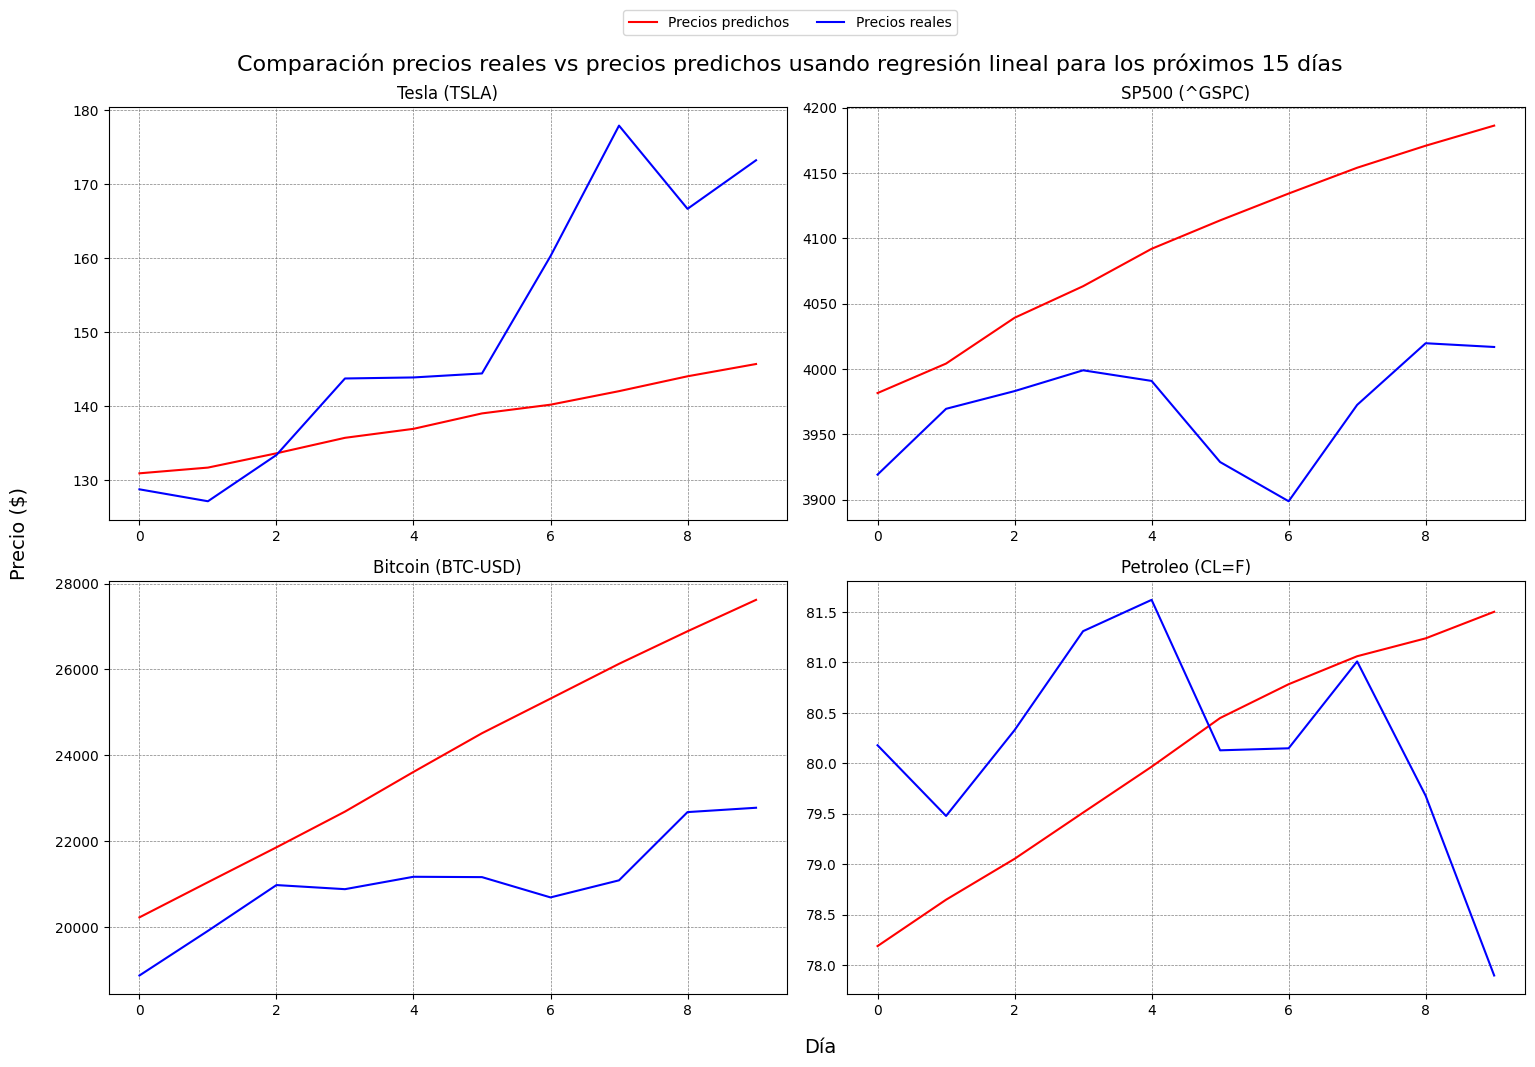

In [20]:
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, model_svr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, model_svr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, model_svr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, model_svr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM

Preparamos los datos de entrenamiento

In [21]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [22]:
def create_lstm(units, activation):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_tesla = KerasRegressor(build_fn=create_lstm)
lstm_sp500 = KerasRegressor(build_fn=create_lstm)
lstm_bitcoin = KerasRegressor(build_fn=create_lstm)
lstm_petroleo = KerasRegressor(build_fn=create_lstm)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}

grid_search_tesla = GridSearchCV(estimator=lstm_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_sp500 = GridSearchCV(estimator=lstm_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_bitcoin = GridSearchCV(estimator=lstm_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_petroleo = GridSearchCV(estimator=lstm_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=0)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_8960\3279703967.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_tesla = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_8960\3279703967.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_sp500 = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_8960\3279703967.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_bitcoin = KerasRegressor(build_fn=create_lstm)
C:\Users\Samuel Valer Nast

102/102 [==============================] - 4s 13ms/step - loss: 0.1012
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 256}
Mejor resultado para Tesla:  0.9813959731583807
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 512}
Mejor resultado para SP500:  0.9934637987059602
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 128}
Mejor resultado para Bitcoin:  0.9754596446004781
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 24}
Mejor resultado para Petróleo:  0.9250064070048123


3/3 [==============================] - 2s 50ms/step
Tesla (TSLA)
RMSE:  5.932645439845032
MSE:  35.19628191491406
MAE:  4.571418869663292
R²:  0.8285544533001287


3/3 [==============================] - 0s 69ms/step
SP500 (^GSPC)
RMSE:  42.4189428276249
MSE:  1799.36671061331
MAE:  34.79007000990314
R²:  0.7737929131497436


4/4 [==============================] - 0s 11ms/step
Bitcoin (BTC-USD)
RMSE:  749.2098647619221
MSE:  561315.4214565776
MAE:  574.3567934782609
R²:  0.9296516473930534


3/3 [==============================] - 0s 5ms/step
Petroleo (CL=F)
RMSE:  1.8716664222457153
MSE:  3.5031351961620767
MAE:  1.4403984281751852
R²:  0.7970531026805651




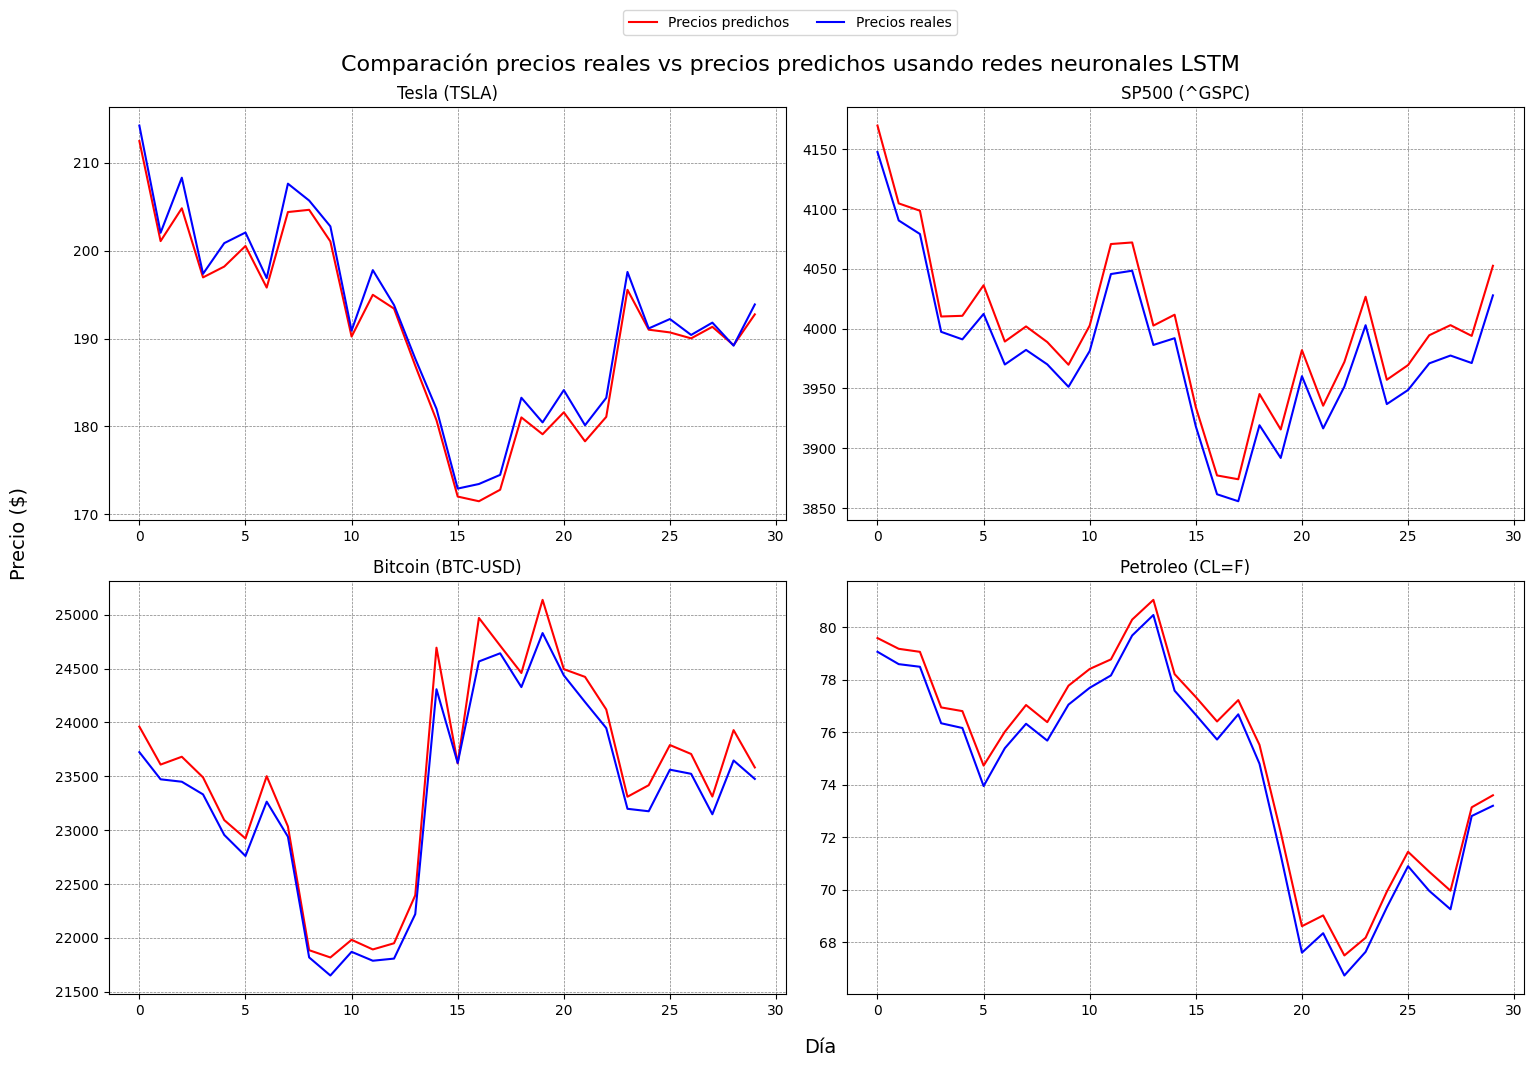

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_tesla = Sequential()
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
lstm_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
lstm_tesla.add(Dense(units = 1))

lstm_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = lstm_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(lstm_tesla, 'lstm_tesla.h5')


lstm_sp500 = Sequential()
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
lstm_sp500.add(Dense(units = 1))
lstm_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = lstm_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = lstm_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(lstm_sp500, 'lstm_sp500.h5')


lstm_bitcoin = Sequential()
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=True))
lstm_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
lstm_bitcoin.add(Dense(units = 1))
lstm_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = lstm_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(lstm_bitcoin, 'lstm_bitcoin.h5')


lstm_petroleo = Sequential()
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
lstm_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
lstm_petroleo.add(Dense(units = 1))
lstm_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = lstm_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(lstm_petroleo, 'lstm_petroleo.h5')


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  14.272747883311872
MSE:  203.71133214058355
MAE:  12.173911539713544
R²:  -3.2823350139097682


SP500 (^GSPC)
RMSE:  141.53552030491747
MSE:  20032.303507983703
MAE:  132.9262858072917
R²:  -14.991452163787923


Bitcoin (BTC-USD)
RMSE:  1601.6567953060521
MSE:  2565304.489950053
MAE:  1323.8033854166667
R²:  -0.07387069698150883


Petroleo (CL=F)
RMSE:  4.746774217692612
MSE:  22.531865473751306
MAE:  4.4303110758463555
R²:  -0.9231615365165264




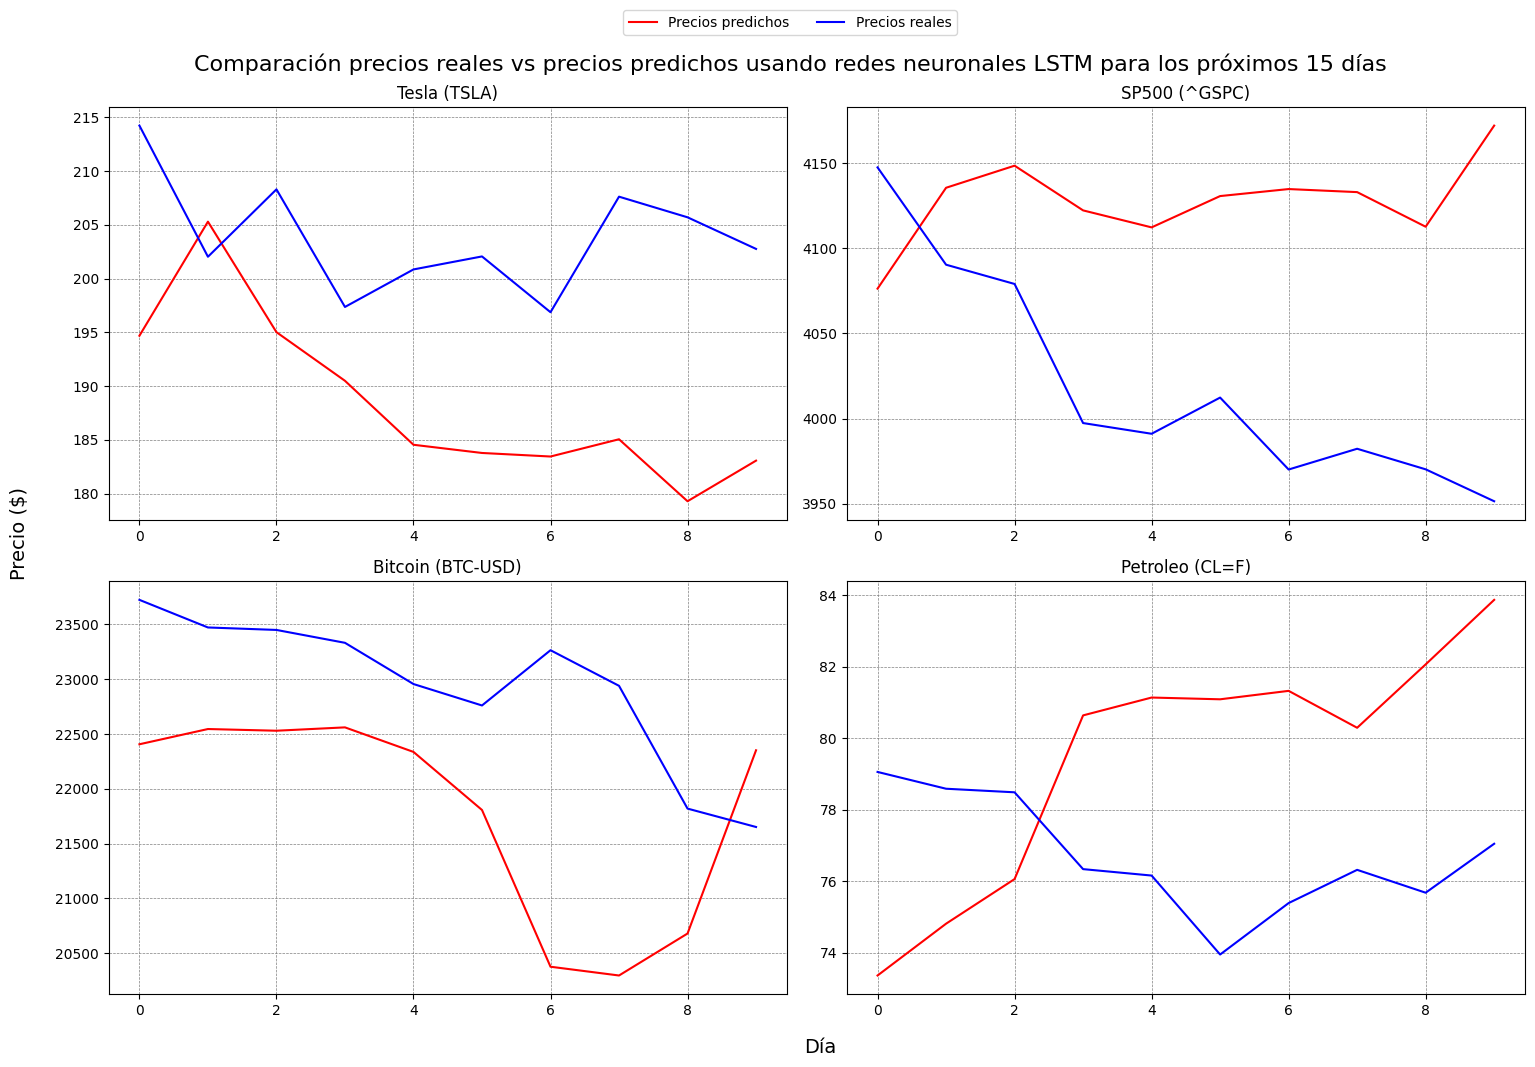

In [25]:
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[pasos_tesla:pasos_tesla*3], pasos_tesla, dias, lstm_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[pasos_sp500:pasos_sp500*3], pasos_sp500, dias, lstm_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[pasos_bitcoin:pasos_bitcoin*3], pasos_bitcoin, dias, lstm_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[pasos_petroleo:pasos_petroleo*3], pasos_petroleo, dias, lstm_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# GRU

In [26]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)

In [27]:
def create_gru(units, activation):
    model = Sequential()
    model.add(GRU(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

gru_tesla = KerasRegressor(build_fn=create_gru)
gru_sp500 = KerasRegressor(build_fn=create_gru)
gru_bitcoin = KerasRegressor(build_fn=create_gru)
gru_petroleo = KerasRegressor(build_fn=create_gru)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}

grid_search_tesla = GridSearchCV(estimator=gru_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_sp500 = GridSearchCV(estimator=gru_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_bitcoin = GridSearchCV(estimator=gru_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=0)
grid_search_petroleo = GridSearchCV(estimator=gru_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=0)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_8960\1278804985.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_tesla = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_8960\1278804985.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_sp500 = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_8960\1278804985.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  gru_bitcoin = KerasRegressor(build_fn=create_gru)
C:\Users\Samuel Valer Nasta\AppD

102/102 [==============================] - 23s 202ms/step - loss: 0.0223
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 256}
Mejor resultado para Tesla:  0.9901618969611828
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 512}
Mejor resultado para SP500:  0.9965606770541893
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 512}
Mejor resultado para Bitcoin:  0.9926495175274281
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 512}
Mejor resultado para Petróleo:  0.9824009282800302


3/3 [==============================] - 1s 33ms/step
Tesla (TSLA)
RMSE:  5.869705309113925
MSE:  34.453440415840205
MAE:  4.4816582908093086
R²:  0.8320765842298191


3/3 [==============================] - 1s 29ms/step
SP500 (^GSPC)
RMSE:  37.5243052854977
MSE:  1408.0734871592301
MAE:  29.430595290492924
R²:  0.8145744380106141


4/4 [==============================] - 2s 71ms/step
Bitcoin (BTC-USD)
RMSE:  704.6177805503535
MSE:  496486.21666770615
MAE:  535.6438519021739
R²:  0.9365554496751851


3/3 [==============================] - 0s 57ms/step
Petroleo (CL=F)
RMSE:  1.7197565118467792
MSE:  2.957562460039401
MAE:  1.369481298658583
R²:  0.834261779762512




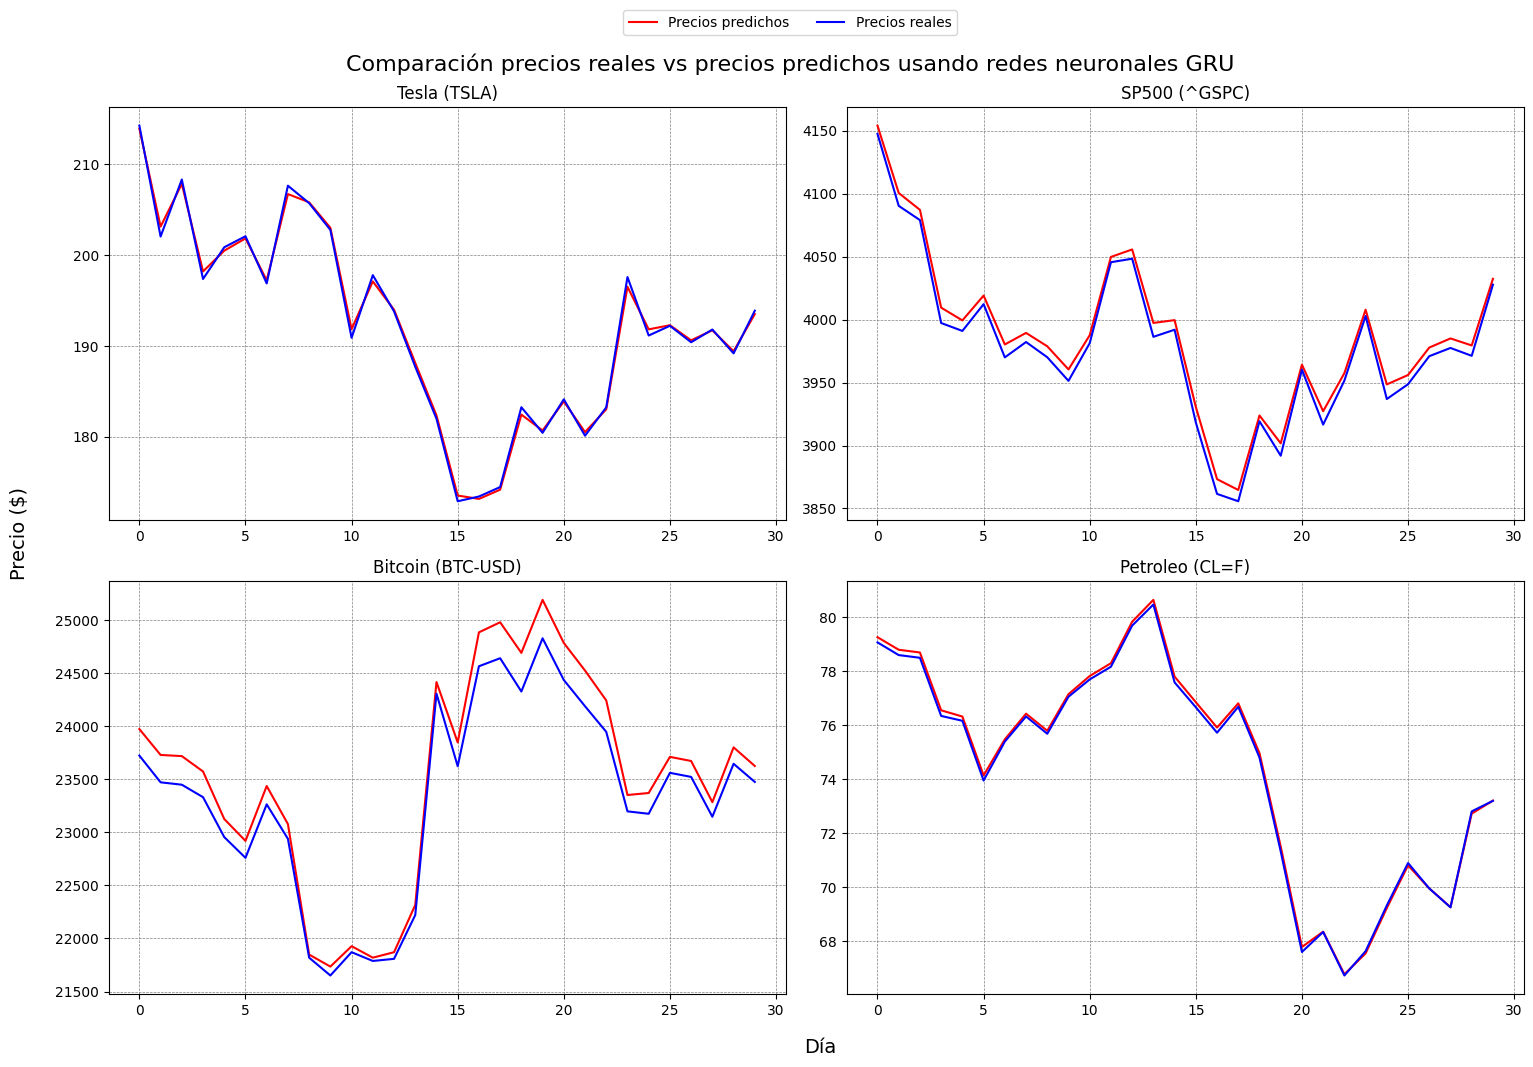

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

gru_tesla = Sequential()
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=True))
gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
gru_tesla.add(Dense(units = 1))

gru_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = gru_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = gru_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(gru_tesla, 'gru_tesla.h5')


gru_sp500 = Sequential()
gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=False))
gru_sp500.add(Dense(units = 1))
gru_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = gru_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = gru_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(gru_sp500, 'gru_sp500.h5')


gru_bitcoin = Sequential()
gru_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
gru_bitcoin.add(Dense(units = 1))
gru_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = gru_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = gru_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(gru_bitcoin, 'gru_bitcoin.h5')

gru_petroleo = Sequential()
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=True))
gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
gru_petroleo.add(Dense(units = 1))
gru_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = gru_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = gru_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(gru_petroleo, 'gru_petroleo.h5')

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  11.604287971981995
MSE:  134.659499336686
MAE:  9.35102742513021
R²:  -1140.6191058024096


SP500 (^GSPC)
RMSE:  188.40218264822622
MSE:  35495.382426615586
MAE:  174.47159830729177
R²:  -42.0193235534738


Bitcoin (BTC-USD)
RMSE:  3470.7812859582696
MSE:  12046322.73495814
MAE:  2887.446484375
R²:  -4.36711564660721


Petroleo (CL=F)
RMSE:  4.833131193321449
MSE:  23.359157131856815
MAE:  4.508072408040369
R²:  -21.42045187882163




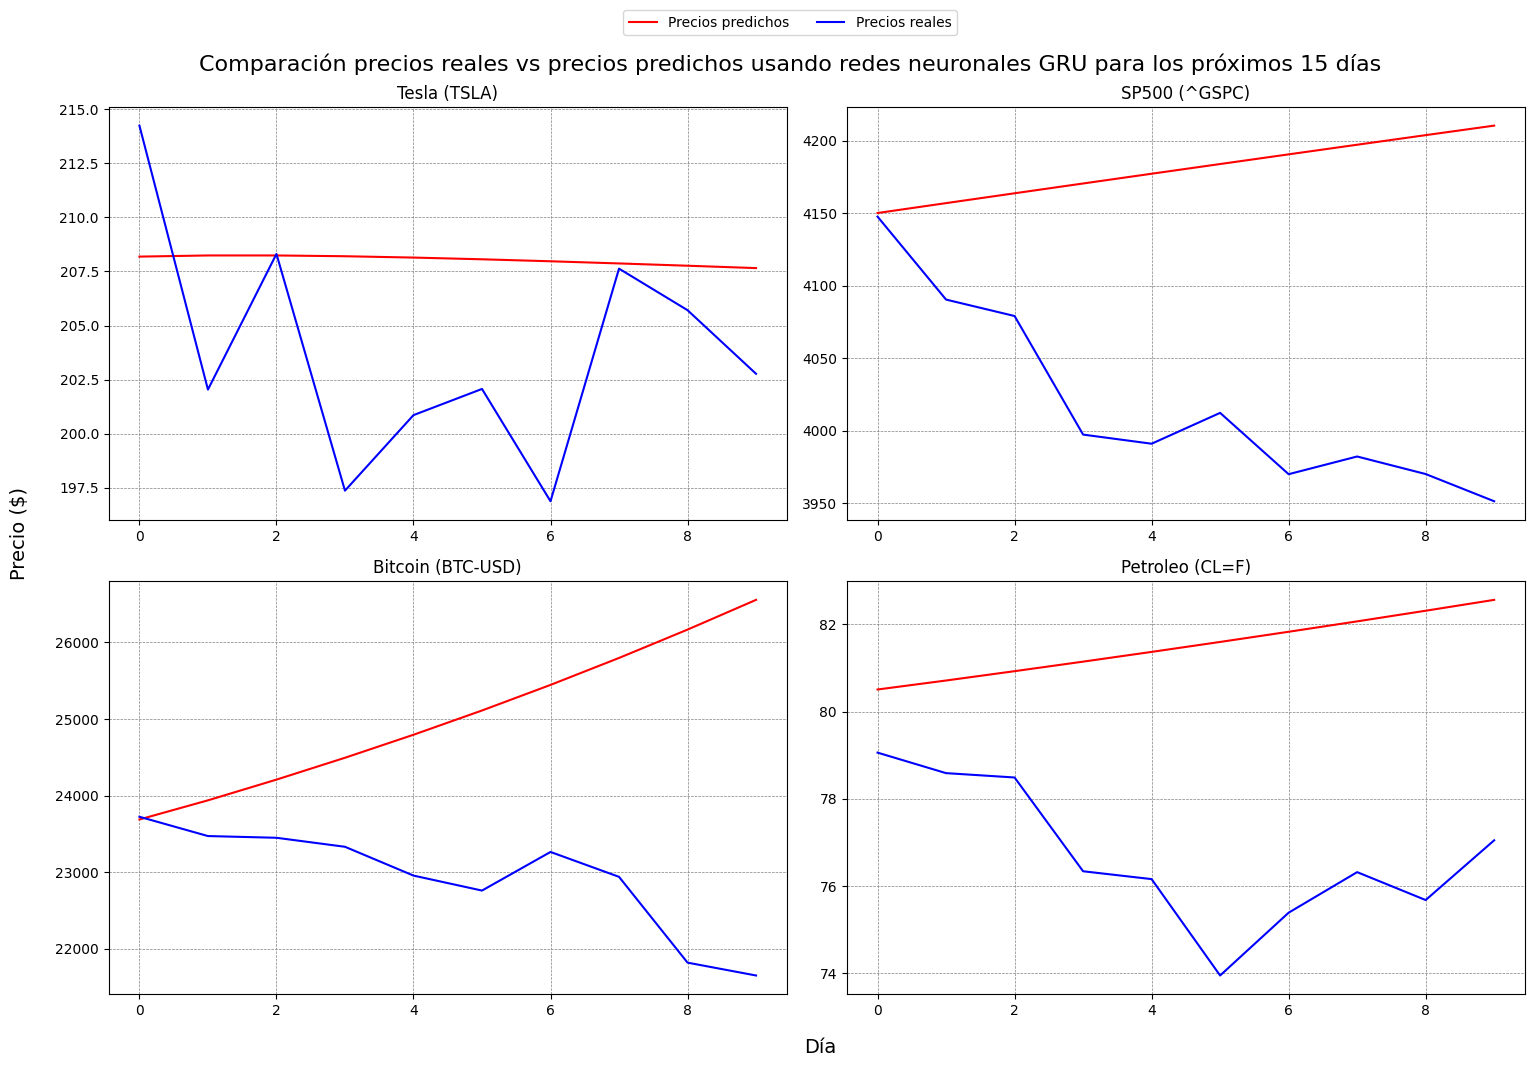

In [30]:
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales GRU para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM + GRU

In [31]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 30
pasos_sp500 = 30
pasos_bitcoin = 30
pasos_petroleo = 30

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [32]:
def create_lstm_gru(units, activation):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(None, 1), return_sequences=True))
    model.add(LSTM(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=True))
    model.add(GRU(units=units, activation=activation, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


lstm_gru_tesla = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_sp500 = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_bitcoin = KerasRegressor(build_fn=create_lstm_gru)
lstm_gru_petroleo = KerasRegressor(build_fn=create_lstm_gru)

param_grid = {
    'units': [6, 12, 24, 36, 64, 128, 256, 512],
    'activation': ['relu', 'sigmoid']
}


grid_search_tesla = GridSearchCV(estimator=lstm_gru_tesla, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_sp500 = GridSearchCV(estimator=lstm_gru_sp500, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_bitcoin = GridSearchCV(estimator=lstm_gru_bitcoin, param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search_petroleo = GridSearchCV(estimator=lstm_gru_petroleo, param_grid=param_grid, cv=3, scoring='r2', verbose=1)

grid_search_tesla.fit(x_train_tesla, y_train_tesla)
grid_search_sp500.fit(x_train_sp500, y_train_sp500)
grid_search_bitcoin.fit(x_train_bitcoin, y_train_bitcoin)
grid_search_petroleo.fit(x_train_petroleo, y_train_petroleo)

print("Mejores parámetros para Tesla: ", grid_search_tesla.best_params_)
print("Mejor resultado para Tesla: ", grid_search_tesla.best_score_)

print("Mejores parámetros para SP500: ", grid_search_sp500.best_params_)
print("Mejor resultado para SP500: ", grid_search_sp500.best_score_)

print("Mejores parámetros para Bitcoin: ", grid_search_bitcoin.best_params_)
print("Mejor resultado para Bitcoin: ", grid_search_bitcoin.best_score_)

print("Mejores parámetros para Petróleo: ", grid_search_petroleo.best_params_)
print("Mejor resultado para Petróleo: ", grid_search_petroleo.best_score_)


C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_8960\202839310.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_tesla = KerasRegressor(build_fn=create_lstm_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_8960\202839310.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_sp500 = KerasRegressor(build_fn=create_lstm_gru)
C:\Users\Samuel Valer Nasta\AppData\Local\Temp\ipykernel_8960\202839310.py:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_gru_bitcoin = KerasRegressor(build_fn=create_lstm_gru)
C:\Us

Fitting 3 folds for each of 16 candidates, totalling 48 fits
98/98 [==============================] - 38s 352ms/step - loss: 0.0106
Fitting 3 folds for each of 16 candidates, totalling 48 fits
102/102 [==============================] - 39s 244ms/step - loss: 0.0137
Fitting 3 folds for each of 16 candidates, totalling 48 fits
94/94 [==============================] - 20s 42ms/step - loss: 0.0123
Fitting 3 folds for each of 16 candidates, totalling 48 fits
102/102 [==============================] - 62s 455ms/step - loss: 0.0764
Mejores parámetros para Tesla:  {'activation': 'relu', 'units': 512}
Mejor resultado para Tesla:  0.9810633114582198
Mejores parámetros para SP500:  {'activation': 'relu', 'units': 256}
Mejor resultado para SP500:  0.9935511160990397
Mejores parámetros para Bitcoin:  {'activation': 'relu', 'units': 64}
Mejor resultado para Bitcoin:  0.9753740493355426
Mejores parámetros para Petróleo:  {'activation': 'relu', 'units': 512}
Mejor resultado para Petróleo:  0.905806702

function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

3/3 [==============================] - 1s 94ms/step
Tesla (TSLA)
RMSE:  6.792797830756027
MSE:  46.14210236952378
MAE:  5.3633356228680675
R²:  0.7734114679441043


3/3 [==============================] - 0s 21ms/step
SP500 (^GSPC)
RMSE:  43.594853273171275
MSE:  1900.5112319093323
MAE:  35.56992737676056
R²:  0.7416375349365367


4/4 [==============================] - 0s 4ms/step
Bitcoin (BTC-USD)
RMSE:  665.2478097986583
MSE:  442554.6484419119
MAE:  501.1561990489131
R²:  0.9392576880887624


3/3 [==============================] - 0s 31ms/step
Petroleo (CL=F)
RMSE:  1.716785522239404
MSE:  2.9473525293708227
MAE:  1.3668829600016277
R²:  0.8311638263913927




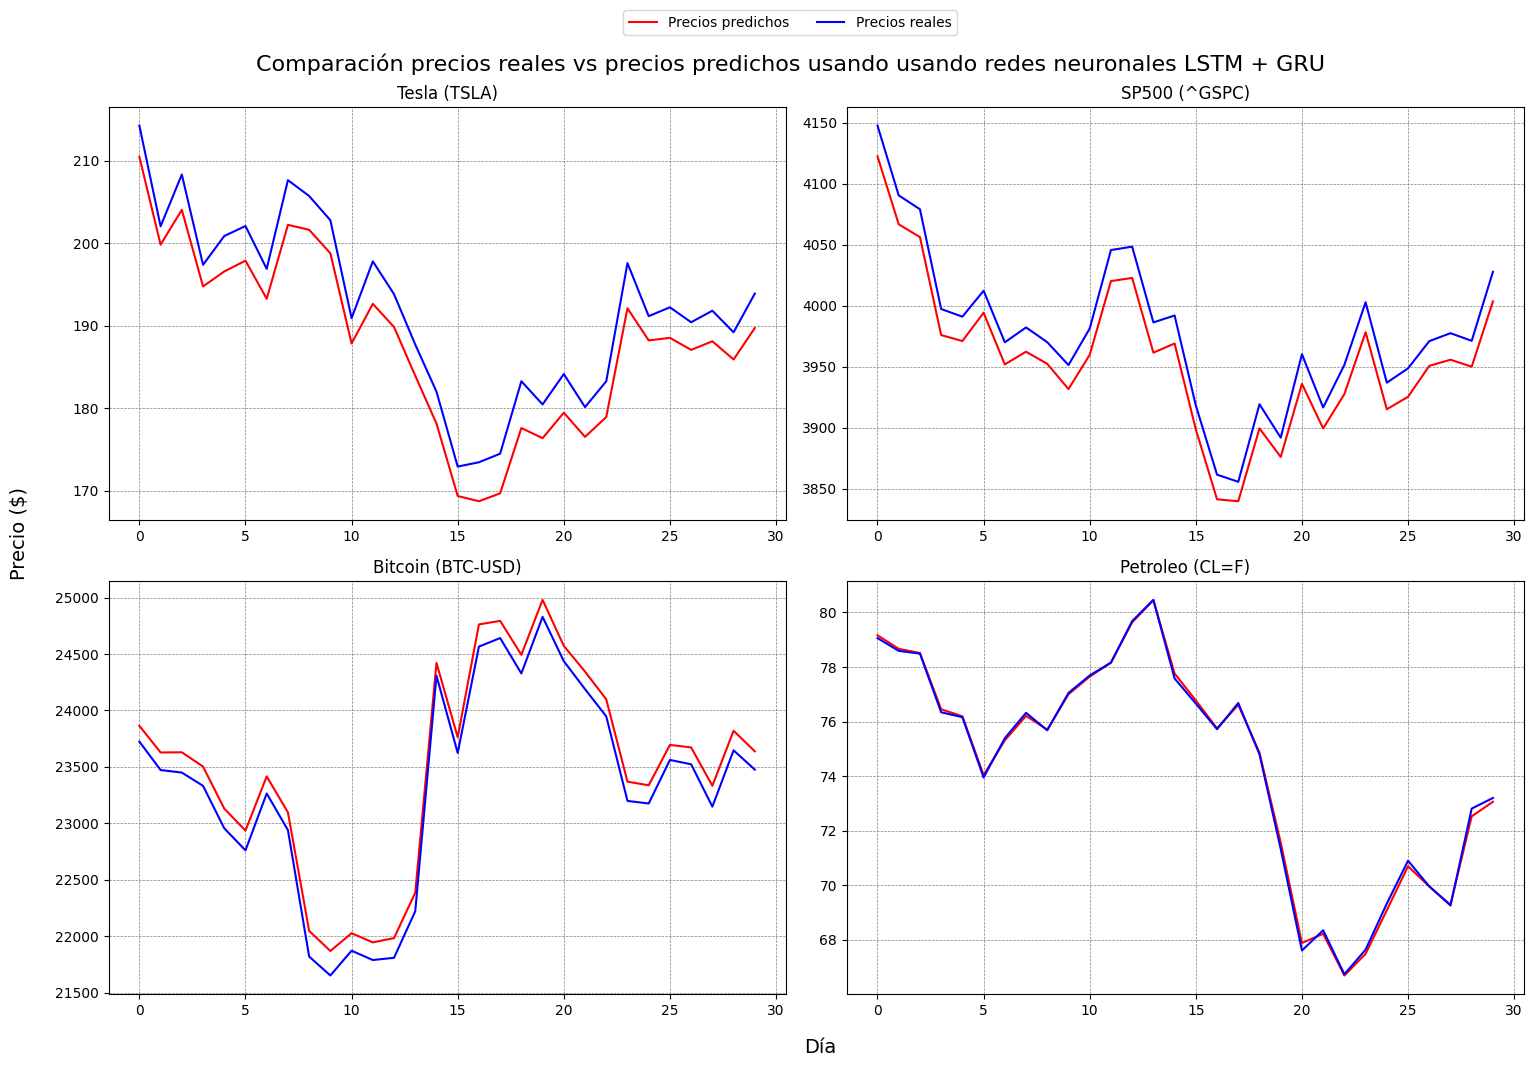

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_gru_tesla = Sequential()
lstm_gru_tesla.add(LSTM(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_tesla.add(GRU(units = grid_search_tesla.best_params_['units'], activation = grid_search_tesla.best_params_['activation'], return_sequences=False))
lstm_gru_tesla.add(Dense(units = 1))
lstm_gru_tesla.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = lstm_gru_tesla.fit(x_train_tesla, y_train_tesla, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_gru_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0], scaler_tesla)
save_model(lstm_gru_tesla, 'lstm_gru_tesla.h5')

lstm_gru_sp500 = Sequential()
lstm_gru_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_sp500.add(LSTM(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=True))
lstm_gru_sp500.add(GRU(units = grid_search_sp500.best_params_['units'], activation = grid_search_sp500.best_params_['activation'], return_sequences=False))
lstm_gru_sp500.add(Dense(units = 1))
lstm_gru_sp500.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_sp500.fit(x_train_sp500, y_train_sp500, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_sp500.evaluate(x_sp500_t, y_sp500_t, batch_size=32)
y_pred_sp500_t = lstm_gru_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1], scaler_sp500)
save_model(lstm_gru_sp500, 'lstm_gru_sp500.h5')

lstm_gru_bitcoin = Sequential()
lstm_gru_bitcoin.add(LSTM(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_bitcoin.add(GRU(units = grid_search_bitcoin.best_params_['units'], activation = grid_search_bitcoin.best_params_['activation'], return_sequences=False))
lstm_gru_bitcoin.add(Dense(units = 1))
lstm_gru_bitcoin.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_gru_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)
save_model(lstm_gru_bitcoin, 'lstm_gru_bitcoin.h5')


lstm_gru_petroleo = Sequential()
lstm_gru_petroleo.add(LSTM(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], input_shape = (None, 1), return_sequences=True))
lstm_gru_petroleo.add(GRU(units = grid_search_petroleo.best_params_['units'], activation = grid_search_petroleo.best_params_['activation'], return_sequences=False))
lstm_gru_petroleo.add(Dense(units = 1))
lstm_gru_petroleo.compile(optimizer='adam', loss='mean_squared_error')
history = lstm_gru_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=200, batch_size=32, verbose = False)
score = lstm_gru_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_gru_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)
save_model(lstm_gru_petroleo, 'lstm_gru_petroleo.h5')


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando usando redes neuronales LSTM + GRU', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  22.615233371011495
MSE:  511.448780425312
MAE:  19.538369750976564
R²:  -0.9081578694994017


SP500 (^GSPC)
RMSE:  82.82569028671014
MSE:  6860.09497147003
MAE:  59.06352539062497
R²:  -0.0044976349064460575


Bitcoin (BTC-USD)
RMSE:  2111.2543166517235
MSE:  4457394.789580536
MAE:  1725.6319010416667
R²:  -8.590037010384243


Petroleo (CL=F)
RMSE:  3.5175528462952554
MSE:  12.373178026479854
MAE:  3.1008946736653695
R²:  -290.10293164147924




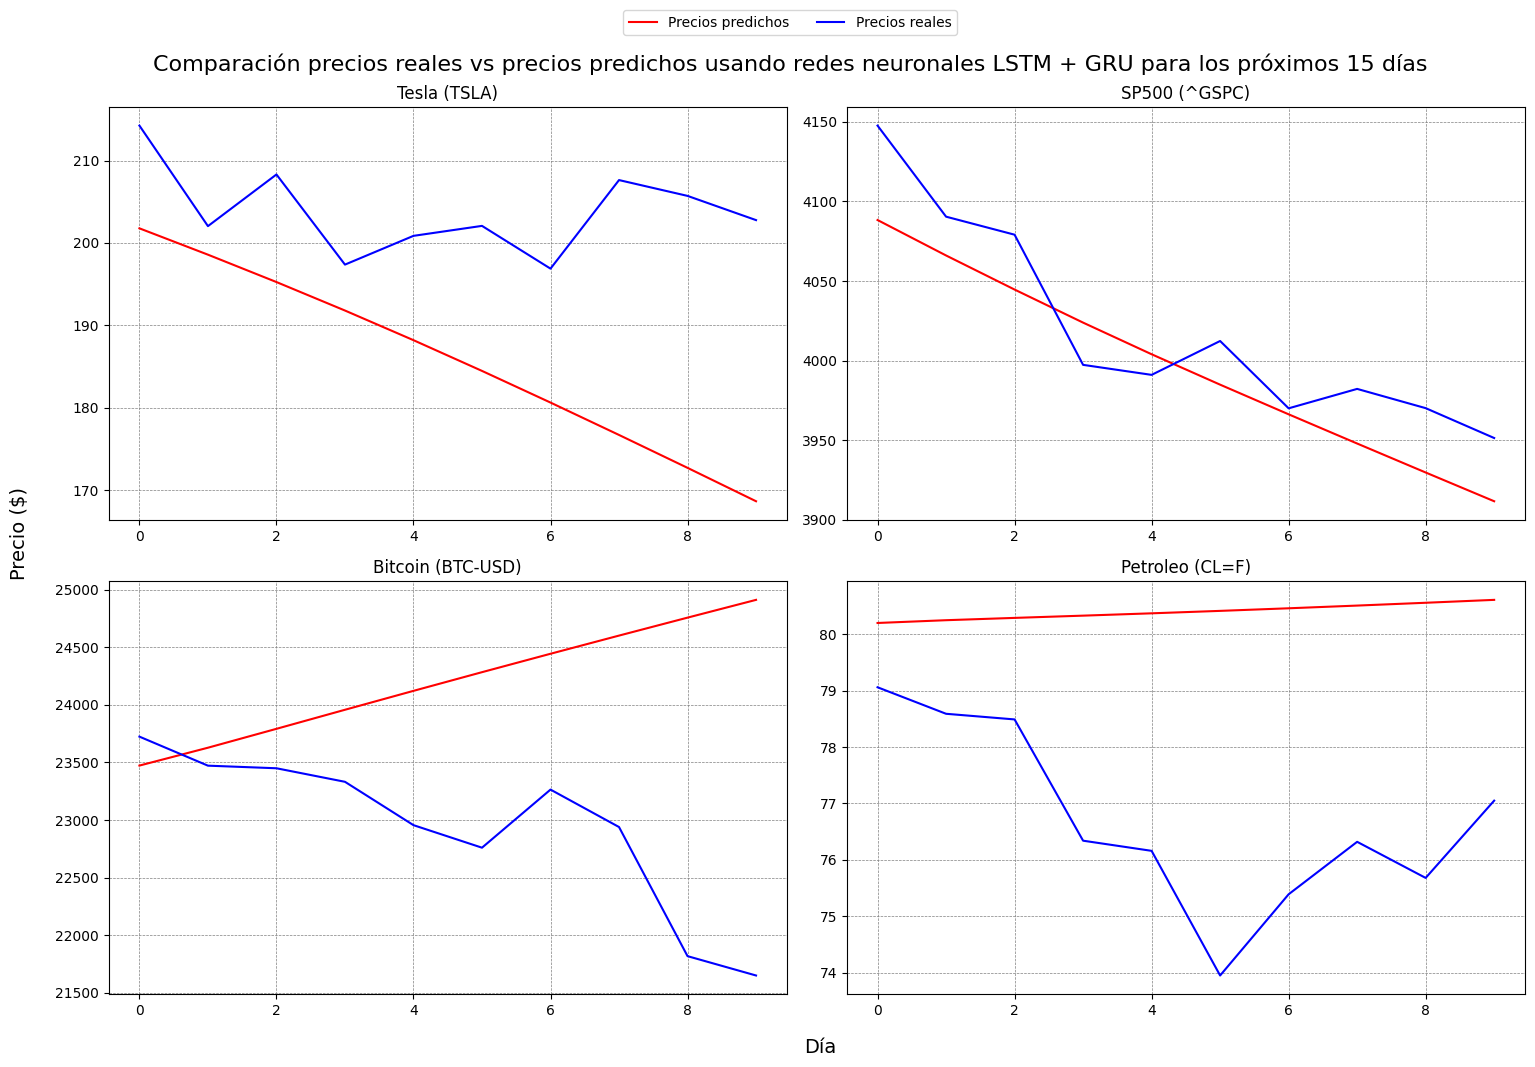

In [34]:
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, lstm_gru_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0], scaler_tesla)

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, lstm_gru_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1], scaler_sp500)

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, lstm_gru_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0], scaler_bitcoin)

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, lstm_gru_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1], scaler_petroleo)

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando redes neuronales LSTM + GRU para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()